In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from prettytable import PrettyTable

from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset

from l5kit.dataset import EgoDatasetVectorized, EgoDataset
from l5kit.vectorization.vectorizer_builder import build_vectorizer
from l5kit.rasterization.rasterizer_builder import build_rasterizer

from l5kit.simulation.dataset import SimulationConfig
from l5kit.simulation.unroll import ClosedLoopSimulator
from l5kit.cle.closed_loop_evaluator import ClosedLoopEvaluator, EvaluationPlan
from l5kit.cle.metrics import (CollisionFrontMetric, CollisionRearMetric, CollisionSideMetric,
                               DisplacementErrorL2Metric, DistanceToRefTrajectoryMetric)
from l5kit.cle.validators import RangeValidator, ValidationCountingAggregator

from l5kit.visualization.visualizer.zarr_utils import simulation_out_to_visualizer_scene
from l5kit.visualization.visualizer.visualizer import visualize
from bokeh.io import output_notebook, show
from l5kit.data import MapAPI
from l5kit.visualization.visualizer.zarr_utils import simulation_out_to_visualizer_scene

from collections import defaultdict
import os


In [2]:
# set env variable for data
from src.constant import SRC_PATH


os.environ["L5KIT_DATA_FOLDER"] = "/workspace/datasets/"
dm = LocalDataManager(None)
# get config
cfg = load_config_data(f"{SRC_PATH}src/configs/rasternet.yaml")
model_path = f"{SRC_PATH}src/model/planning_model_20201208.pt"
# model_path = "./BPTT.pt"
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = 'cpu'
model = torch.load(model_path)
# model = SAC.load("/home/pronton/rl/l5kit/examples/RL/gg colabs/logs/SAC_640000_steps.zip")
model = model.eval()
torch.set_grad_enabled(False)

/root/.local/share/virtualenvs/l5kit-ZbMednhg/lib/python3.8/site-packages/torch/serialization.py:779: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"


In [3]:
eval_cfg = cfg["val_data_loader"]
eval_zarr = ChunkedDataset(dm.require(eval_cfg["key"])).open()
# vectorizer = build_vectorizer(cfg, dm)
# eval_dataset = EgoDatasetVectorized(cfg, eval_zarr, vectorizer)
vectorizer = build_rasterizer(cfg, dm)
eval_dataset = EgoDataset(cfg, eval_zarr, vectorizer)
print(eval_dataset)
num_scenes_to_unroll = 100
num_simulation_steps = None

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   16220    |  4030296   | 312617887  |    29277930   |      111.97     |        248.48        |        77.57         |        24.85         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [4]:
# ==== DEFINE CLOSED-LOOP SIMULATION
sim_cfg = SimulationConfig(use_ego_gt=False, use_agents_gt=True, disable_new_agents=True,
                           distance_th_far=500, distance_th_close=50, num_simulation_steps=num_simulation_steps,
                           start_frame_index=0, show_info=True)

sim_loop = ClosedLoopSimulator(sim_cfg, eval_dataset, device, model_ego=model, model_agents=None)

In [5]:
# ==== UNROLL
# sample 100 scenes at equally part of the whole 16220 scenes
scenes_to_unroll = list(range(0, len(eval_zarr.scenes), len(eval_zarr.scenes)//num_scenes_to_unroll))
sim_outs = sim_loop.unroll(scenes_to_unroll)

/workspace/source/l5kit2/l5kit/l5kit/data/zarr_dataset.py:213: RuntimeWarning: zarr dataset path should end with .zarr (for now). Open will fail for this dataset!
  dataset = ChunkedDataset("")
/workspace/source/l5kit2/l5kit/l5kit/simulation/utils.py:107: RuntimeWarning: zarr dataset path should end with .zarr (for now). Open will fail for this dataset!
  new_dataset = ChunkedDataset("")


  0%|          | 0/248 [00:00<?, ?it/s]

/root/.local/share/virtualenvs/l5kit-ZbMednhg/lib/python3.8/site-packages/torch/nn/modules/module.py:1190: UserWarning: operator() profile_node %2261 : int[] = prim::profile_ivalue(%2259)
 does not have profile information (Triggered internally at ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:105.)
  return forward_call(*input, **kwargs)


In [6]:
from src.validate.validator import compute_ade_fde, quantify_outputs
ades, fdes = compute_ade_fde(sim_outs)
quantify_outputs(sim_outs)

+----------+----------+----------+----------+-----+-----+--------+----------+
| scene_id |   FDE    |   ADE    |   DRT    |  CF |  CR |   CS   |   PEGO   |
+----------+----------+----------+----------+-----+-----+--------+----------+
|    0     | 42.6998  |  9.4956  |  0.4624  | 0.0 | 0.0 |  0.0   |  1.9035  |
|   162    |  5.6234  |  0.8245  |  0.2388  | 0.0 | 0.0 |  0.0   |  1.3318  |
|   324    | 14.4699  |  2.7124  |  0.1969  | 0.0 | 0.0 |  0.0   |  2.3136  |
|   486    |  5.9491  |  3.3278  |  0.4966  | 0.0 | 0.0 |  0.0   |  1.0293  |
|   648    |  0.0006  |  0.0006  |  0.0005  | 0.0 | 0.0 |  0.0   |   0.0    |
|   810    |  1.314   |  1.9947  |  0.0548  | 0.0 | 0.0 |  0.0   |  1.131   |
|   972    |  3.5016  |  2.6971  |  0.2042  | 0.0 | 0.0 |  0.0   |  0.1866  |
|   1134   | 24.0281  | 10.0546  |  0.308   | 0.0 | 0.0 |  1.0   | -2.0106  |
|   1296   |   0.0    |   0.0    |   0.0    | 0.0 | 0.0 |  0.0   |   0.0    |
|   1458   | 20.3496  |  2.2075  |  0.0406  | 0.0 | 0.0 |  0.0  

In [7]:
import numpy as np
print(round(np.mean(ades),2), round((np.std(ades)),2) ,round((np.max(ades) - np.min(ades))/2,2))
print(round(np.mean(fdes),2), round((np.std(fdes)),2) ,round((np.max(fdes) - np.min(fdes))/2,2))
sorted_ades_idx = sorted(range(len(ades)), key=lambda i: ades[i], reverse=True)
sorted_fdes_idx = sorted(range(len(fdes)), key=lambda i: fdes[i], reverse=True)
# sorted(range(len(ades)), key=lambda i: ades[i])[-10:]
print(f'Top worst scence based on ade:{sorted_ades_idx[:10]}')
print(f'Top best scence based on ade:{sorted_ades_idx[:-10:-1]}')
print(f'Top worst scence based on fde:{sorted_fdes_idx[:10]}')
print(f'Top best scence based on fde:{sorted_fdes_idx[:-10:-1]}')

8.13 18.01 67.69
19.18 39.26 144.08
Top worst scence based on ade:[32, 91, 22, 17, 62, 53, 84, 34, 96, 76]
Top best scence based on ade:[66, 60, 59, 57, 42, 39, 8, 16, 74]
Top worst scence based on fde:[32, 17, 91, 22, 84, 23, 94, 53, 62, 96]
Top best scence based on fde:[66, 60, 59, 57, 42, 39, 8, 98, 4]


+-------------------------+-------+
|          metric         | value |
+-------------------------+-------+
|  displacement_error_l2  |   12  |
| distance_ref_trajectory |   3   |
|     collision_front     |   0   |
|      collision_rear     |   10  |
|      collision_side     |   1   |
+-------------------------+-------+


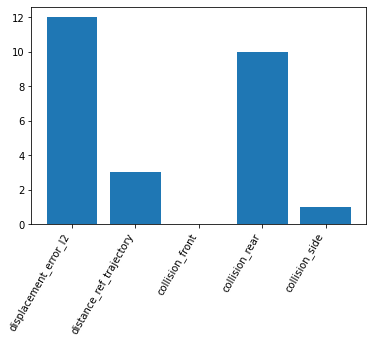

In [8]:
from src.validate.validator import CLEValidator
import matplotlib.pyplot as plt
import numpy as np

agg = CLEValidator(sim_outs)
fields = ["metric", "value"]
table = PrettyTable(field_names=fields)

values = []
names = []

for metric_name in agg:
    table.add_row([metric_name, agg[metric_name].item()])
    values.append(agg[metric_name].item())
    names.append(metric_name)

print(table)

plt.bar(np.arange(len(names)), values)
plt.xticks(np.arange(len(names)), names, rotation=60, ha='right')
plt.show()

In [ ]:
# might change with different rasterizer
mapAPI = MapAPI.from_cfg(dm, cfg)

def visualize_outputs(sim_outs, map_API):
    for sim_out in sim_outs: # for each scene
        vis_in = simulation_out_to_visualizer_scene(sim_out, map_API)
        # print(vis_in)
        # break
        show(visualize(sim_out.scene_id, vis_in))

output_notebook()

### Best ade

In [ ]:
# might change with different rasterizer

mapAPI = MapAPI.from_cfg(dm, cfg)
sim_outs_selected = [sim_outs[i] for i in sorted_ades_idx[-3:-1]]
visualize_outputs(sim_outs_selected, mapAPI)

### Worst ade

In [ ]:
# might change with different rasterizer
mapAPI = MapAPI.from_cfg(dm, cfg)
sim_outs_selected = [sim_outs[i] for i in sorted_ades_idx[:3]]
visualize_outputs(sim_outs_selected, mapAPI)